In [1]:
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import gc
from tqdm import tqdm_notebook
from itertools import product
import sklearn
import scipy.sparse 
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [2]:
DATA_FOLDER = '~/.kaggle/competitions/competitive-data-science-final-project/'

transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test            = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))


Having loaded the data, let's examine it

In [4]:
transactions.describe(include = 'all')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
unique,1034,NaN,NaN,NaN,NaN,NaN
top,28.12.2013,NaN,NaN,NaN,NaN,NaN
freq,9434,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,NaN,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,NaN,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,NaN,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,NaN,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,NaN,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00


There are some high price values that will need to be examined.

In [6]:
transactions.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [7]:
items.describe(include = 'all')

,item_name,item_id,item_category_id
count,22170,22170.00000,22170.000000
unique,22170,NaN,NaN
top,Набор для сборки машинки T1 Track Car Single,NaN,NaN
freq,1,NaN,NaN
mean,NaN,11084.50000,46.290753
std,NaN,6400.07207,15.941486
min,NaN,0.00000,0.000000
25%,NaN,5542.25000,37.000000
50%,NaN,11084.50000,40.000000
75%,NaN,16626.75000,58.000000


In [8]:
shops.describe(include = 'all')

,shop_name,shop_id,shop_city
count,60,60.000000,60.000000
unique,60,NaN,NaN
top,"_�__����_____�_�_�____�� _�_�__ ""_�_�___���_�_...",NaN,NaN
freq,1,NaN,NaN
mean,NaN,29.500000,16.333333
std,NaN,17.464249,8.150422
min,NaN,0.000000,1.000000
25%,NaN,14.750000,10.750000
50%,NaN,29.500000,15.000000
75%,NaN,44.250000,22.000000


In [9]:
item_categories.describe(include = 'all')

,item_category_name,item_category_id
count,84,84.000000
unique,84,NaN
top,Подарки - Атрибутика,NaN
freq,1,NaN
mean,NaN,41.500000
std,NaN,24.392622
min,NaN,0.000000
25%,NaN,20.750000
50%,NaN,41.500000
75%,NaN,62.250000


Here is the summary of what we have:
shop id, item id and date block are needed to arrange the date. Additional usable fields from across several files are:
item count, item price, shop city, shop name, shop city, item name, item category, item category id
That's it. This is not a feature rich data set.
Let's try to combine transactions and items and see what kind of data we have for a specified shop, just as an example:
  

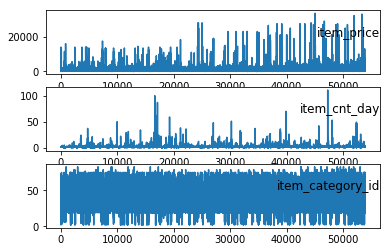

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,19.01.2013,0,26,12691,449.0,1.0,КОЛЛЕКЦИЯ Р. СКОТТА (Гладиатор/Робин Гуд) (2DVD),40
1,13.01.2013,0,26,12714,149.0,1.0,КОЛОМБИАНА (регион),40
2,06.01.2013,0,26,12718,299.0,1.0,"КОМАНДА ""А"" (BD)",37
3,21.01.2013,0,26,12719,149.0,1.0,КОМАНДА 8,40
4,30.01.2013,0,26,13370,299.0,1.0,Компл.вопр.серт.экзам.1С:Бухгалтерия 8 (ред.3....,49


In [11]:
select_store = 26
data_df = transactions.loc[(transactions['shop_id'] == select_store)]
data_df = pd.merge(data_df, items, how = 'left', on = ['item_id'])

         #PLOT SELECTED COLUMNS FOR THE SELECTED STORE
values = data_df.values
to_plot = [4, 5,7] 
i=1
plt.figure()
for item in to_plot:
    plt.subplot(len(to_plot), 1, i)
    plt.plot(values[:, item])
    #plt.yticks([])
    plt.title(data_df.columns[item], y=0.5, loc='right')
    i += 1
plt.show()


data_df.head()



it would be also interesting to look at the behavior of stores as time series. I already know from prior EDA that stores 12 and 9 are causing the model to deteriorate massively. let's see if we find the cause. I will plot total item count by month for selected stores, including the problematic ones.


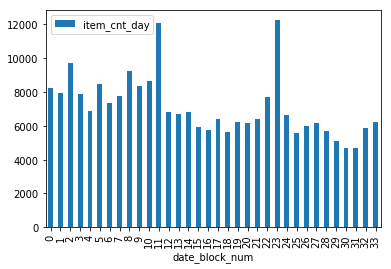

In [13]:
temp = transactions.groupby(['shop_id','date_block_num'], as_index = False).sum()

#Plot store 25 = normal
temp_rev = temp[temp['shop_id'] == 25][['date_block_num','item_cnt_day']]
temp_rev.set_index('date_block_num',inplace = True)
temp_rev.plot(kind = 'bar')


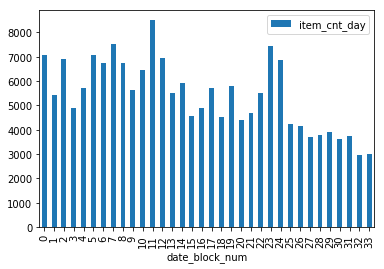

In [14]:
#another normal store 28
temp_rev = temp[temp['shop_id'] == 28][['date_block_num','item_cnt_day']]
temp_rev.set_index('date_block_num',inplace = True)
temp_rev.plot(kind = 'bar')


This is actually quite typical for this data set. there is a down time trend, and spikes in December. I have to predict November, so the seasonal spike is less of a concern. Let's look now at the stores that are not behaving well


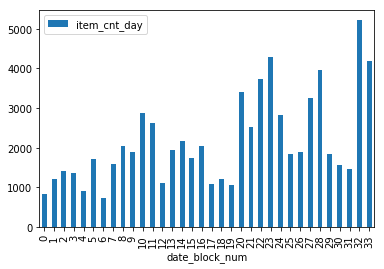

In [16]:
    #store 12 first:
temp_rev = temp[temp['shop_id'] == 12][['date_block_num','item_cnt_day']]
temp_rev.set_index('date_block_num',inplace = True)
temp_rev.plot(kind = 'bar')


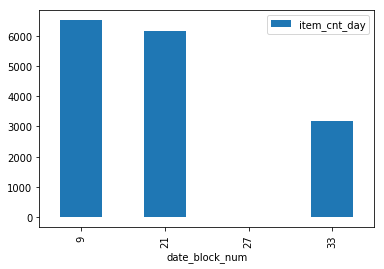

In [17]:
#and this is store 9
temp_rev = temp[temp['shop_id'] == 9][['date_block_num','item_cnt_day']]
temp_rev.set_index('date_block_num',inplace = True)
temp_rev.plot(kind = 'bar')


Both stores 12 and 9 reveal very atypical patterns. I have already run the model without any data set exclusions and uploaded the prediction just to test the waters; fixing the problems associated with these 2 is highly likely to improve the results significantly. To the point: exclusion of just shop12 from the dataset resulted in the R2 improvement from 0.253/0.316 to 0.575/0.670 on the validation set for linear regression and light gbm, respectively.
    
Now let's take a look whether there are outliers in the last month as suggested by store 12 data; in this case I am looking for large values in target (this is month 33) that would not have correspondingly large values in previous months. Here we are:


In [24]:
sales = transactions

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})

# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 

# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();


#now create lags


# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift



/Applications/anaconda3/envs/tensorflow/lib/python2.7/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


HBox(children=(IntProgress(value=0, max=12), HTML(value=u'')))

In [27]:
temp_alone_all = all_data[(all_data['date_block_num'].isin([31,32,33])) & (all_data['target'] > 70) 
                      & (all_data['target_lag_1'] <= 5) & (all_data['target_lag_2'] <= 5) & (all_data['target_lag_3'] <= 5)]

temp_alone_all.head()

,shop_id,item_id,date_block_num,target,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_5,target_lag_6,target_lag_7,target_lag_8,target_lag_9,target_lag_10,target_lag_11,target_lag_12
10242580,42,11354,31,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10350097,59,6507,31,102.0,2.0,1.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10457876,42,3351,32,136.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10508726,25,3351,32,146.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10630596,12,15067,32,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As expected, these values include stores 12 and 9. I have checked product descriptions for these one-time spikes, and while most of them belong to computer games (apparently just came out) which makes sense, there are several other data points which suggest that these are not repeatable transactions. I will make an adjustment for these as I tune up the model.
I addition, store 12 has the following outlier:
 

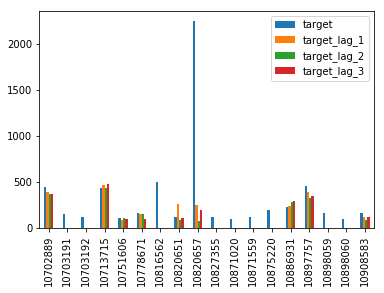

In [28]:
temp_large = all_data[(all_data['date_block_num']== 33) & (all_data['target'] > 100)]
temp_large[['target', 'target_lag_1', 'target_lag_2', 'target_lag_3']].plot(kind =  'bar')


Looking at this, it's pretty clear that the value should be clipped, or perhaps better normalized. I think it's the culprit in the form of item 11373 in store 12 at time 33 only which is delivery by mail. I will replace it with a normalized value and manipulate the individual valuein the submission set.


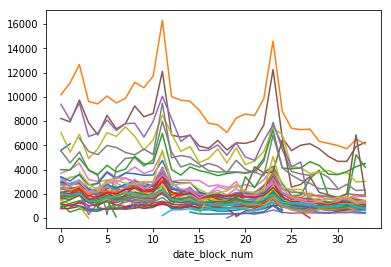

In [29]:
transactions.groupby(['date_block_num', 'shop_id']).sum()['item_cnt_day'].unstack().plot(legend = None)

While the above is not the cleanest graph, it's actually very informative. Again, thinking of the outliers: I see spikes in the penultimate and last months that shouldn't be there. Remember: the spikes in previous years are December, and the data stops in October. Let's examine this a little closer:

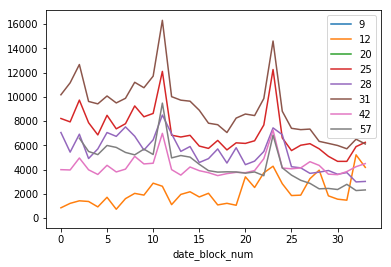

In [35]:
temp = transactions.groupby(['date_block_num', 'shop_id']).sum()['item_cnt_day'].unstack()
temp = temp.T
temp = temp[temp[33] > 2000]
temp = temp.T
temp.plot().legend()


There you go. As a minimum, same store 12 is messing things up here, but perhaps store 25 deserves some attention. I will take care of the outliers and things should be in good shape.